In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from pydub import AudioSegment
import numpy as np
import scipy.signal
import scipy.stats
import ffmpeg
import os

-48.8557352973482 44.37558541496024
6.634896601021217


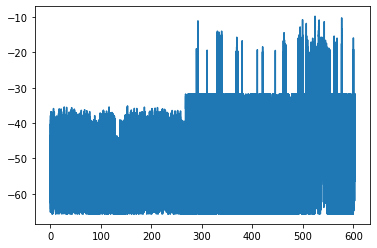

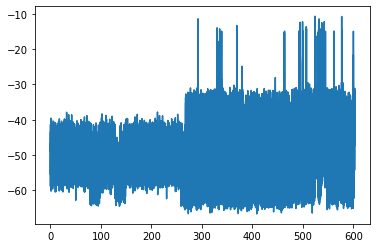

In [12]:
input_video = "input/00.mp4"
song = AudioSegment.from_file(input_video)
song = song.set_channels(1)
framerate = song.frame_rate
time = song.duration_seconds

N = 1
db = np.array([song[i].dBFS for i in range(0, len(song), N)]) #dBFSに変換
del song # メモリ解放
length = len(db)

# 不可聴外れ値の除去
mean = scipy.stats.trim_mean(db, 0.45)
var = scipy.stats.trim_mean(abs(db - mean)**2, 0.45)
print(mean, var)
with np.errstate(invalid='ignore'):
    Abnormality = (db-mean)**2/var

threshold = scipy.stats.chi2.isf(0.01, 1)
print(threshold)
#new_db = db.copy()
for i in range(length):
    if Abnormality[i]>threshold and db[i] < -20:
        db[i] = mean

t = np.array([i*time/length for i in range(length)])

plt.plot(t, db, label='signal')
plt.show()

# 平滑化
new_db = x = scipy.signal.savgol_filter(db, 10, 2)

plt.plot(t, new_db, label='signal')
plt.show()

del t

In [8]:
mean = scipy.stats.trim_mean(db, 0.45)
print(mean)

-48.855735297348204


In [14]:
### 開始時間と終了時間をelse内で決める処理に変更して、ピンポイントで切り抜けるようにしたい

clip_range = 1#秒
clip_margin = 1#前後n秒 2秒が標準 1は局所切り抜き

if clip_margin >= 2:
  end_add = 1
else:
  end_add = 0

if os.path.isdir("out"):
  fl = os.listdir("out")
  for f in fl:
    os.remove("out/"+f)
else:
  os.mkdir("out")

length_1sec = int(length/time) # 1秒当たりのサンプル数
step =  length_1sec* clip_range # 1ループのステップ

# ループ重要関数初期化
count = 0
margin_tmp = 0
start_time = 0
end_time = 0
clip_flag = False # クリップ範囲かどうか
for i in range(0, len(db), step):
  # if i>800*length_1sec:
  #   break
  now = i / length_1sec
  max_db = db[i:int(i+step)].max()
  
  if max_db > mean//3:
    clip_flag = True # クリップ中
    start_time = now - clip_margin
    if start_time < 0:start_time = 0 # 開始時間が0より小さい時0
    if start_time < end_time: # 開始時間が前の終了時間より早い時
      start_time = start_tmp # 開始時間を一つ前に戻す
    else:
      start_tmp = start_time
    end_time = now + clip_margin
    if end_time > time:end_time = time
    i += clip_margin
  else:
    if clip_flag == True: #クリップ中なら
      if now-end_time > clip_margin: # 今がクリップ、マージンの外なら
        clip_flag = False
        count += 1
        print(f"\r{count:03}.  {start_time}-{end_time}: {end_time-start_time}sec   ", end="")
        stream = ffmpeg.input(input_video, ss=start_time, to=end_time).output(f"out/{count:03}.mp4")
        ffmpeg.run(stream)
        #if count>50:break
    
import ctypes

#Windowsのスリープ
# ctypes.windll.PowrProf.SetSuspendState(0, 1, 0)

016.  599.0-601.0: 2.0sec   

In [8]:
import ffmpeg
import os

def concat(v_list, dir):
    for i in range(0,len(v_list),10):
        videos = v_list[i:i+10]
        #print(videos)
        with open("tmp.txt", "w") as fp:
            lines = [f"file '{dir}/{line}'" for line in videos] # file 'パス' という形式にする
            fp.write("\n".join(lines))
        # ffmpegで結合（再エンコードなし）
        ffmpeg.input("tmp.txt", f="concat", safe=0).output(f"concat/{i:03}.mp4", c="copy").run(overwrite_output=True)

def concat2(v_list, dir, outdir):
    for i in range(0,len(v_list),10):
        videos = v_list[i:i+10]
        #print(videos)
        with open("tmp.txt", "w") as fp:
            lines = [f"file '{dir}/{line}'" for line in videos] # file 'パス' という形式にする
            fp.write("\n".join(lines))
        # ffmpegで結合（再エンコードなし）
        ffmpeg.input("tmp.txt", f="concat", safe=0).output(f"{outdir}/{i:03}.mp4", c="copy").run(overwrite_output=True)

dir = "concat/"
videos = os.listdir(dir)  # 結合するファイルのパス

for v in videos:
    os.remove(dir+v)

dir = "out/"
videos = os.listdir(dir)  # 結合するファイルのパス


# 一旦テキストファイルに書き出す
import time
# 書き出さない方法は、あまりにファイル数が多い場合に「コマンド長すぎ」と怒られる
concat(videos, dir)
c = 0
#print("a")
while(True):
    c += 1
    if c%2 == 1:dir, outdir= "concat/", "concat2/"
    else:dir,outdir = "concat2/", "concat/"
    videos = os.listdir(dir)  # 結合するファイルのパス
    if len(videos)<=1:
        break
    concat2(videos, dir, outdir)
    for v in videos:
        os.remove(dir+v)